<a href="https://colab.research.google.com/github/NeePatel121/patel/blob/main/Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -s "/content/drive/MyDrive/Colab Notebooks/Healthcare/Splitted" "/content/splitted"
!ln -s "/content/drive/MyDrive/Colab Notebooks/Healthcare/utils1.py" "/content/"

In [44]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Healthcare')
import os
import shutil
import random
import utils
import networks

import numpy as np
import matplotlib.pyplot as plt
from plot_utils import plot_summary, plot_confmat, plot_gradcam
from grad_cam import GradCAM

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler

In [4]:
dirs = {
    'train': '/content/splitted/train',
    'val': '/content/splitted/val',
    'test': '/content/splitted/test'
}

In [5]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transforms.ToTensor())
val_set = datasets.ImageFolder(root=dirs['val'], transform=transforms.ToTensor())
test_set = datasets.ImageFolder(root=dirs['test'], transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)

In [6]:
train_set.classes
train_set.class_to_idx

{'covid_19': 0, 'lung_opacity': 1, 'normal': 2, 'pneumonia': 3}

In [7]:
print(f'Number of Images in Train Set: {len(train_set)}')
print(f'Number of Images in Validation Set: {len(val_set)}')
print(f'Number of Images in Test Set: {len(test_set)}')

Number of Images in Train Set: 12712
Number of Images in Validation Set: 240
Number of Images in Test Set: 240


In [8]:
freq_train = torch.as_tensor(train_set.targets).bincount()
freq_val = torch.as_tensor(val_set.targets).bincount()
freq_test = torch.as_tensor(test_set.targets).bincount()
freq_all = freq_train + freq_test + freq_val

In [9]:
def log_freq(dset, dfreq):
    for c, i in dset.class_to_idx.items():
        print(f'Number of {c.capitalize()} X-Rays: {dfreq[i].item()}')

In [10]:
print('========== Train Set ==========')
log_freq(train_set, freq_train)
print('======== Validation Set ========')
log_freq(val_set, freq_val)
print('=========== Test Set ===========')
log_freq(test_set, freq_test)

========== Train Set ==========
Number of Covid_19 X-Rays: 3496
Number of Lung_opacity X-Rays: 2946
Number of Normal X-Rays: 5045
Number of Pneumonia X-Rays: 1225
======== Validation Set ========
Number of Covid_19 X-Rays: 60
Number of Lung_opacity X-Rays: 60
Number of Normal X-Rays: 60
Number of Pneumonia X-Rays: 60
=========== Test Set ===========
Number of Covid_19 X-Rays: 60
Number of Lung_opacity X-Rays: 60
Number of Normal X-Rays: 60
Number of Pneumonia X-Rays: 60


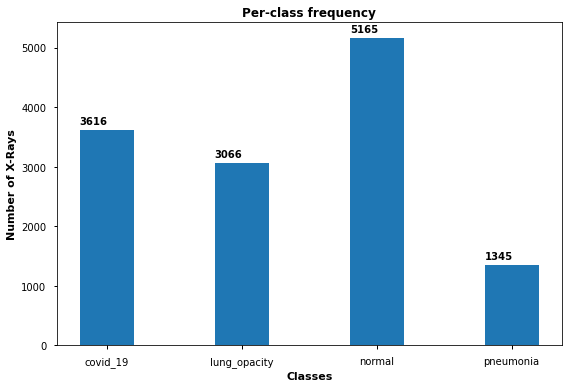

In [11]:
plt.style.use('seaborn-notebook')

plt.bar(train_set.classes, freq_all.numpy(), width=0.4)

for i, v in enumerate(freq_all.numpy()):
    plt.text(i-.2, v+100, str(v), fontweight='bold')

plt.xlabel('Classes', fontweight='bold')
plt.ylabel('Number of X-Rays', fontweight='bold')
plt.title('Per-class frequency', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Healthcare/outputs/class_freq.png')

plt.show()
plt.close()

In [12]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Healthcare')

In [13]:
import utils
import networks
from plot_utils import plot_summary

In [14]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=utils.transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=utils.transform['eval'])

In [15]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=utils.wif)
valid_dl = DataLoader(val_set, batch_size=40)

In [21]:
epochs = 30
criterion = nn.CrossEntropyLoss()

In [17]:
!ln -s "/content/drive/MyDrive/Colab Notebooks/Healthcare/Models" "/content/Models"

In [18]:
resnet18 = networks.get_resnet18(pretrained=True, out_features=4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [22]:
utils.fit(
    epochs=epochs,
    model=resnet18,
    criterion=criterion,
    optimizer=optim.Adam(resnet18.parameters(), lr=3e-5),
    train_dl=train_dl,
    valid_dl=valid_dl
)

  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.025752	Avg valid loss: 0.134680

		valid_loss decreased (inf -> 0.134680)
		saving model...



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.023860	Avg valid loss: 0.155472



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.020804	Avg valid loss: 0.099364

		valid_loss decreased (0.134680 -> 0.099364)
		saving model...



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.013721	Avg valid loss: 0.093071

		valid_loss decreased (0.099364 -> 0.093071)
		saving model...



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.009280	Avg valid loss: 0.147305



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.011893	Avg valid loss: 0.142581



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.007414	Avg valid loss: 0.139913



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.008395	Avg valid loss: 0.085229

		valid_loss decreased (0.093071 -> 0.085229)
		saving model...



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.007001	Avg valid loss: 0.106688



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.006801	Avg valid loss: 0.134502



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.006261	Avg valid loss: 0.143642



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.004315	Avg valid loss: 0.125939



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.005838	Avg valid loss: 0.134958



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.010339	Avg valid loss: 0.121181



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.004264	Avg valid loss: 0.152752



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.003430	Avg valid loss: 0.165738



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.005248	Avg valid loss: 0.103408



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.003016	Avg valid loss: 0.189389



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.005133	Avg valid loss: 0.211223



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.005134	Avg valid loss: 0.191447



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.003321	Avg valid loss: 0.182655



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.004265	Avg valid loss: 0.178610



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.002583	Avg valid loss: 0.151404



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.002913	Avg valid loss: 0.156671



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.003631	Avg valid loss: 0.163324



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.008365	Avg valid loss: 0.150734



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.001896	Avg valid loss: 0.177532



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.002380	Avg valid loss: 0.163191



  0%|          | 0/398 [00:00<?, ?it/s]


		Avg train loss: 0.003079	Avg valid loss: 0.193720



Epoch [30/30]: 100%|██████████| 398/398 [01:06<00:00,  6.02it/s, acc=0.614, loss=0.000165]



		Avg train loss: 0.001969	Avg valid loss: 0.241627



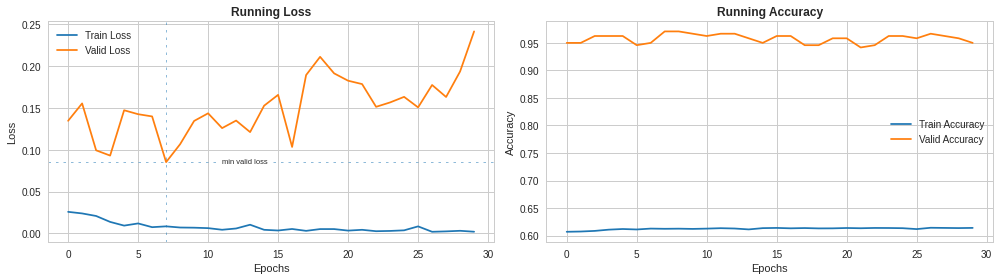

In [23]:
plot_summary('/content/drive/MyDrive/Colab Notebooks/Healthcare/outputs/CSVs/resnet.csv')

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=utils.transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=utils.transform['eval'])
train_dl = DataLoader(train_set, batch_size=512)
test_dl = DataLoader(test_set, batch_size=120)

In [ ]:
!ln -s "/content/drive/MyDrive/Colab Notebooks/Healthcare/models" "/content/models"

In [27]:
resnet18 = networks.get_resnet18(out_features=4, path='/content/Models/lr3e-5_resnet_cuda.pth')


In [28]:
train_preds = utils.get_all_preds(resnet18, train_dl)

In [29]:
test_preds = utils.get_all_preds(resnet18, test_dl)

In [30]:
train_preds.shape, test_preds.shape

(torch.Size([12712, 4]), torch.Size([240, 4]))

In [32]:
train_correct = utils.get_num_correct(train_preds, torch.as_tensor(train_set.targets, device=device))
test_correct = utils.get_num_correct(test_preds, torch.as_tensor(test_set.targets, device=device))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 12678	Train Accuracy: 99.73%
Test Correct:    232	Test Accuracy:  96.67%


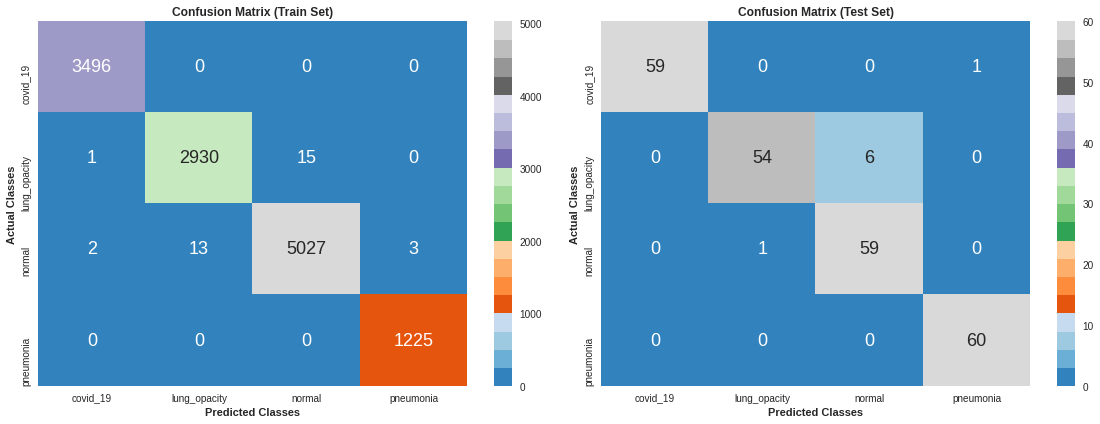

In [35]:
train_confmat = utils.get_confmat(train_set.targets, train_preds)
test_confmat = utils.get_confmat(test_set.targets, test_preds)
plot_confmat(train_confmat, test_confmat, train_set.classes, f'{type(resnet18).__name__.lower()}')


In [36]:
results = utils.get_results(test_confmat, test_set.classes)
results

{'covid_19': [0.9957081545064378, 1.0, 0.9833333333333333, 0.9915966386554621],
 'lung_opacity': [0.9707112970711297,
  0.9818181818181818,
  0.9,
  0.9391304347826087],
 'normal': [0.9707112970711297, 0.9076923076923077, 0.9833333333333333, 0.944],
 'pneumonia': [0.9957081545064378,
  0.9836065573770492,
  1.0,
  0.9917355371900827]}